### Add ThreatMetrix features to the transactions dataframe

In [2]:
import pandas as pd
import numpy as np
import category_encoders
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%load_ext autoreload
%autoreload 2

### Load and Clean TMX

In [2]:
transactions_df = pd.read_parquet('../../artifacts/20200920/transactions_df_unlabeled.parquet')
tmx_df = pd.read_parquet('../../../ach-risk/data/TMX_scores.parquet')
tmx_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709924 entries, 0 to 709923
Data columns (total 24 columns):
 #   Column                              Non-Null Count   Dtype              
---  ------                              --------------   -----              
 0   user_id                             709924 non-null  object             
 1   created_dt                          709924 non-null  datetime64[ns, UTC]
 2   bb_bot_score                        500402 non-null  object             
 3   policy_score                        681025 non-null  object             
 4   bb_fraud_score                      500402 non-null  object             
 5   input_ip_score                      638267 non-null  object             
 6   account_name_score                  561643 non-null  object             
 7   summary_risk_score                  681025 non-null  object             
 8   account_email_score                 596566 non-null  object             
 9   account_number_score      

In [3]:
transactions_df.is_returned.head()

0    False
1     None
2     None
3     None
4     None
Name: is_returned, dtype: object

In [4]:
def parse_str_obj(s, cast_type=str):
    if isinstance(s, str):
        s = s.lstrip('["').rstrip('"]')
        s = cast_type(s)
    return s

In [5]:
tmx_df.columns

Index(['user_id', 'created_dt', 'bb_bot_score', 'policy_score',
       'bb_fraud_score', 'input_ip_score', 'account_name_score',
       'summary_risk_score', 'account_email_score', 'account_number_score',
       'input_ip_worst_score', 'account_address_score',
       'digital_id_trust_score', 'shipping_address_score',
       'challenger_policy_score', 'account_name_worst_score',
       'account_email_worst_score', 'account_number_worst_score',
       'account_address_worst_score', 'shipping_address_worst_score',
       'digital_id_trust_score_rating', 'digital_id_trust_score_reason_code',
       'digital_id_confidence', 'digital_id_confidence_rating'],
      dtype='object')

In [6]:
columns = ['bb_bot_score', 'policy_score',
       'bb_fraud_score', 'input_ip_score', 'account_name_score',
       'summary_risk_score', 'account_email_score', 'account_number_score',
       'input_ip_worst_score', 'account_address_score',
       'digital_id_trust_score', 'shipping_address_score',
       'challenger_policy_score', 'account_name_worst_score',
       'account_email_worst_score', 'account_number_worst_score',
       'account_address_worst_score', 'shipping_address_worst_score',
       'digital_id_trust_score_rating', 'digital_id_trust_score_reason_code',
       'digital_id_confidence', 'digital_id_confidence_rating']

for col in columns:
    tmx_df[col] = tmx_df[col].apply(parse_str_obj)
    
    # if we ccan cast the data as float
    if 'score' in col:
        try:
            tmx_df[col] = tmx_df[col].astype(float)
        except:
            pass
        

In [7]:
tmx_df.head()

,user_id,created_dt,bb_bot_score,policy_score,bb_fraud_score,input_ip_score,account_name_score,summary_risk_score,account_email_score,account_number_score,...,challenger_policy_score,account_name_worst_score,account_email_worst_score,account_number_worst_score,account_address_worst_score,shipping_address_worst_score,digital_id_trust_score_rating,digital_id_trust_score_reason_code,digital_id_confidence,digital_id_confidence_rating
0,15153418,2019-12-11 18:05:59.111383+00:00,500.0,-10.0,500.0,2.0,0.0,-10.0,NaN,0.0,...,-13.0,-61.0,NaN,0.0,0.0,NaN,very_high,"_ts_conf_avg_zero"", ""_ts_very_low_conf_score"",...",0,very_low
1,16341196,2020-07-21 01:19:16.583709+00:00,500.0,0.0,500.0,0.0,0.0,0.0,0.0,NaN,...,5.0,0.0,0.0,NaN,0.0,0.0,very_high,"_ts_very_low_conf_score"", ""_ts_low_entity_age_...",2952,medium
2,16525856,2020-08-11 10:58:36.753718+00:00,500.0,0.0,500.0,1.0,0.0,0.0,0.0,0.0,...,-13.0,0.0,0.0,0.0,0.0,NaN,low,"_ts_low_conf_score"", ""_ts_gbl_ip_black"", ""_ts_...",7566,high
3,16499250,2020-08-08 14:46:18.598669+00:00,500.0,0.0,500.0,0.0,2.0,0.0,0.0,0.0,...,5.0,-24.0,0.0,0.0,NaN,NaN,very_high,"_ts_conf_avg_zero"", ""_ts_very_low_conf_score"",...",0,very_low
4,15498831,2020-02-20 21:55:52.867000+00:00,500.0,0.0,500.0,0.0,NaN,0.0,0.0,NaN,...,5.0,NaN,0.0,NaN,NaN,NaN,very_low,"_ts_conf_avg_zero"", ""_ts_very_low_conf_score"",...",0,very_low


#### Check out features we will first consider

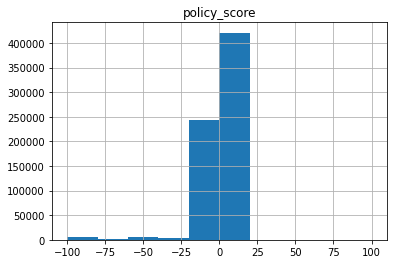

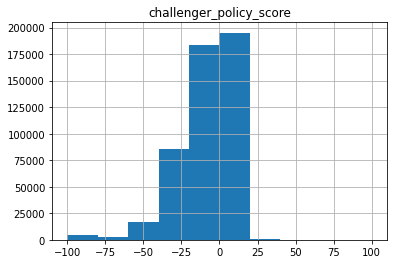

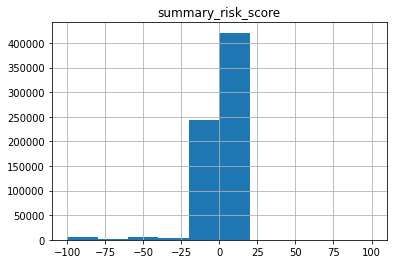

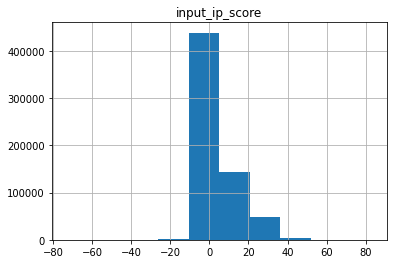

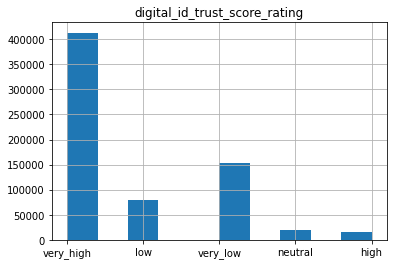

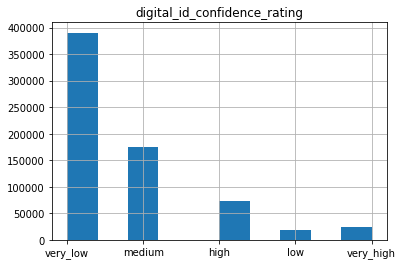

In [8]:
features = ['policy_score', 'challenger_policy_score', 
            'summary_risk_score', 'input_ip_score', 
            'digital_id_trust_score_rating', 'digital_id_confidence_rating']

for f in features:
    tmx_df[f].hist()
    plt.title(f)
    plt.show()

In [9]:
tmx_df.created_dt.head()

0   2019-12-11 18:05:59.111383+00:00
1   2020-07-21 01:19:16.583709+00:00
2   2020-08-11 10:58:36.753718+00:00
3   2020-08-08 14:46:18.598669+00:00
4   2020-02-20 21:55:52.867000+00:00
Name: created_dt, dtype: datetime64[ns, UTC]

#### Create some TMX features
---

In [10]:
cols = tmx_df.columns.to_list()
cols = cols[:1] + list(map(lambda x: 'tmx_'+x, cols[1:]))
tmx_df.columns = cols

In [11]:
tmx_df['user_id'] = tmx_df['user_id'].astype(int)
tmx_df['tmx_created_dt'] = pd.to_datetime(tmx_df['tmx_created_dt']).dt.tz_localize(None)

In [12]:
tmx_df['tmx_digital_id_trust_score_rating'].value_counts()

very_high    412644
very_low     152508
low           79256
neutral       19935
high          15404
Name: tmx_digital_id_trust_score_rating, dtype: int64

In [13]:
tmx_df['tmx_digital_id_confidence_rating'].value_counts()

very_low     390284
medium       174533
high          73151
very_high     23569
low           19488
Name: tmx_digital_id_confidence_rating, dtype: int64

In [14]:
tmx_rating_map = {'very_low': -2, 
                  'low': -1, 
                  'neutral': 0,
                  'medium': 0,
                  'high': 1,
                  'very_high': 2}
tmx_df['tmx_digital_id_trust_score_rating'] = tmx_df['tmx_digital_id_trust_score_rating'].replace(tmx_rating_map)
tmx_df['tmx_digital_id_confidence_rating'] = tmx_df['tmx_digital_id_confidence_rating'].replace(tmx_rating_map)

In [15]:
tmx_df['tmx_digital_id_confidence'].fillna(np.nan, inplace=True)
tmx_df['tmx_digital_id_confidence'] = tmx_df['tmx_digital_id_confidence'].astype(float)

<AxesSubplot:>

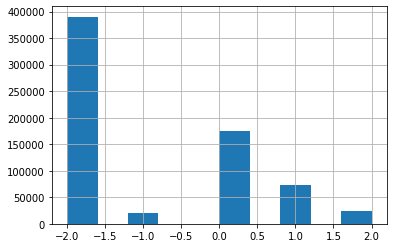

In [16]:
tmx_df['tmx_digital_id_confidence_rating'].hist()

In [17]:
tmx_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709924 entries, 0 to 709923
Data columns (total 24 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   user_id                                 709924 non-null  int64         
 1   tmx_created_dt                          709924 non-null  datetime64[ns]
 2   tmx_bb_bot_score                        500402 non-null  float64       
 3   tmx_policy_score                        681025 non-null  float64       
 4   tmx_bb_fraud_score                      500402 non-null  float64       
 5   tmx_input_ip_score                      638267 non-null  float64       
 6   tmx_account_name_score                  561643 non-null  float64       
 7   tmx_summary_risk_score                  681025 non-null  float64       
 8   tmx_account_email_score                 596566 non-null  float64       
 9   tmx_account_number_score             

In [18]:
tmx_df = tmx_df.sort_values(by=['tmx_created_dt', 'user_id'], ascending=True)

In [19]:
tmx_df['tmx_first_link_dt'] = tmx_df.groupby('user_id')['tmx_created_dt'].cummin()
tmx_df['tmx_last_link_dt'] = tmx_df.groupby('user_id')['tmx_created_dt'].cummax()

In [20]:
tmx_df['tmx_nr_past_tmx'] = tmx_df.groupby('user_id')['user_id'].cumcount()

In [21]:
transactions_df = transactions_df.sort_values(by=['transaction_datetime', 'user_id'], ascending=True)

#### Cleaning Done, Merge with transactions

In [22]:
uid = list(set(tmx_df.user_id).intersection(set(transactions_df.user_id)))[:10]
uid

[11010052,
 14680070,
 15204359,
 12582918,
 13107209,
 16777226,
 15204363,
 16252940,
 16777229,
 14680083]

In [23]:
tmxdf_ = tmx_df[tmx_df.user_id.isin(uid)]
transdf_ = transactions_df[transactions_df.user_id.isin(uid)]

In [24]:
tmxdf_.shape, transdf_.shape

((10, 27), (901, 170))

In [25]:
# debug
# base_df = pd.merge_asof(transdf_, tmxdf_, left_on='transaction_datetime',
#                         right_on='created_dt', by='user_id')
base_df = pd.merge_asof(transactions_df, tmx_df, 
                        left_on='transaction_datetime', 
                        right_on='tmx_created_dt', by='user_id')

In [26]:
base_df.columns

Index(['user_id', 'business_account_number', 'transaction_datetime',
       'transaction_code', 'is_return', 'transaction_amount', 'endbal',
       'external_account_number', 'real_ending_balance',
       'external_institution_id',
       ...
       'tmx_account_number_worst_score', 'tmx_account_address_worst_score',
       'tmx_shipping_address_worst_score', 'tmx_digital_id_trust_score_rating',
       'tmx_digital_id_trust_score_reason_code', 'tmx_digital_id_confidence',
       'tmx_digital_id_confidence_rating', 'tmx_first_link_dt',
       'tmx_last_link_dt', 'nr_past_tmx'],
      dtype='object', length=196)

In [27]:
base_df.to_parquet('../../artifacts/20201005/transactions_df_unlabeled_with_tmx.parquet')

### Add some more features
---

In [3]:
transactions_df = pd.read_parquet('../../artifacts/20201005/transactions_df_unlabeled_with_tmx.parquet')

In [4]:
transactions_df['plaid_days_since_first_link'] = (transactions_df['transaction_datetime'] - \
                                                  transactions_df['plaid_first_link_date']).dt.days
transactions_df['quovo_days_since_first_link'] = (transactions_df['transaction_datetime'] - \
                                                  transactions_df['quovo_first_link_date']).dt.days
transactions_df['tmx_days_since_first_link'] = (transactions_df['transaction_datetime'] - \
                                                  transactions_df['tmx_first_link_dt']).dt.days

In [5]:
transactions_df.to_parquet('../../artifacts/20201005/transactions_df_unlabeled_with_tmx.parquet')